# Transfer Learning - TensorFlow
- Transfer learning tensorflow (RNN/LSTM) models works slightly different than other model types, due to the difficulty of carrying these models in `Forecaster` object history. `Forecater` objects are meant to be be copied and pickled, both of which can fail with tensorflow models. For that reason, it is good to save out tensorflow models manually before using them to transfer learn.
- This notebook also demonstrates transferring confidence intervals.
- Requires `>=0.19.1`.

In [1]:
from scalecast.Forecaster import Forecaster
from scalecast.util import infer_apply_Xvar_selection, find_optimal_transformation
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast import GridGenerator
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd

## Initiate the First Forecaster Object
This series ends December, 2020.

In [2]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2020-12-31',
)

df.head()

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5


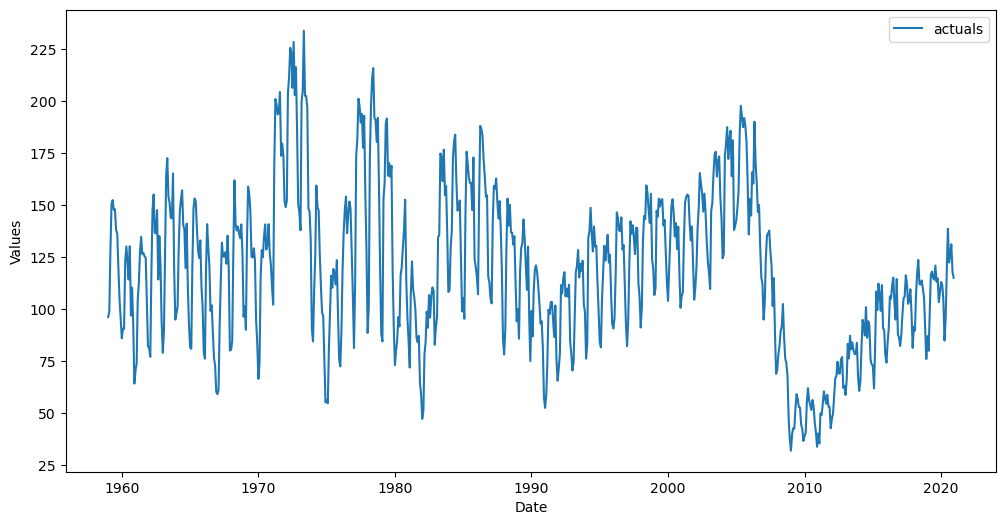

In [3]:
f = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24,
    cis=True,
    test_length = 24,
)

f.plot()
plt.show()

### Fit the RNN Model

In [4]:
f.set_estimator('rnn')
f.manual_forecast(epochs=15,lags=24)

Epoch 1/15
21/21 [==============================] - 2s 8ms/step - loss: 0.4615
Epoch 2/15
21/21 [==============================] - 0s 9ms/step - loss: 0.3677
Epoch 3/15
21/21 [==============================] - 0s 8ms/step - loss: 0.2878
Epoch 4/15
21/21 [==============================] - 0s 8ms/step - loss: 0.2330
Epoch 5/15
21/21 [==============================] - 0s 8ms/step - loss: 0.1968
Epoch 6/15
21/21 [==============================] - 0s 8ms/step - loss: 0.1724
Epoch 7/15
21/21 [==============================] - 0s 8ms/step - loss: 0.1555
Epoch 8/15
21/21 [==============================] - 0s 7ms/step - loss: 0.1454
Epoch 9/15
21/21 [==============================] - 0s 7ms/step - loss: 0.1393
Epoch 10/15
21/21 [==============================] - 0s 8ms/step - loss: 0.1347
Epoch 11/15
21/21 [==============================] - 0s 7ms/step - loss: 0.1323
Epoch 12/15
21/21 [==============================] - 0s 7ms/step - loss: 0.1303
Epoch 13/15
21/21 [==============================

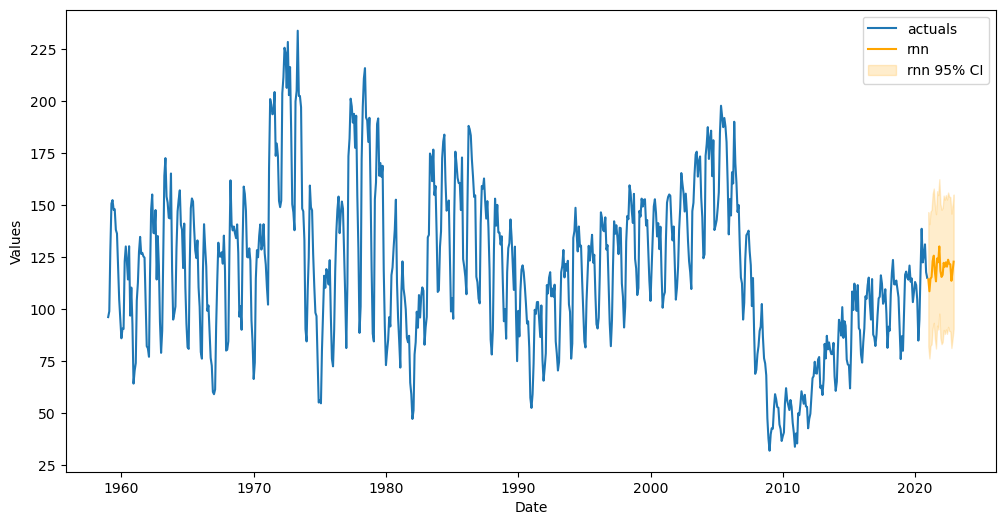

In [5]:
f.plot(ci=True)
plt.show()

### Save the model out
After you fit a tensforflow model, the fit model is attached to the `Forecaster` in the `tf_model` attribute. You can view the model summary:

In [6]:
f.tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 24)                216       
                                                                 
Total params: 296
Trainable params: 296
Non-trainable params: 0
_________________________________________________________________


However, immediately after changing estimators or when the object is pickled out, this attribute is lost. Therefore, it is a good idea to save the model out:

In [7]:
f.save_tf_model(name='model.h5') # default argument

Later, when you want to transfer learn with the model, you can re-attach it to the `Forecaster` object:

In [8]:
f.load_tf_model(name='model.h5') # default argument

This re-attaches the `tf_model` attribute.

## Initiate the Second Forecaster Object

- Later, if we have more data streaming in, instead of refitting a model, we can use the already-fitted model to make the predictions. This updated series is through June, 2023
- You can use an updated version of the original series, you can use the same series with an extended Forecast horizon, or you can use an entirely different series (as long as it's the same frequency) to perform this process

In [9]:
df_new = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

df_new.tail()

,HOUSTNSA
DATE,
2023-02-01,103.2
2023-03-01,114.0
2023-04-01,121.7
2023-05-01,146.0
2023-06-01,132.6


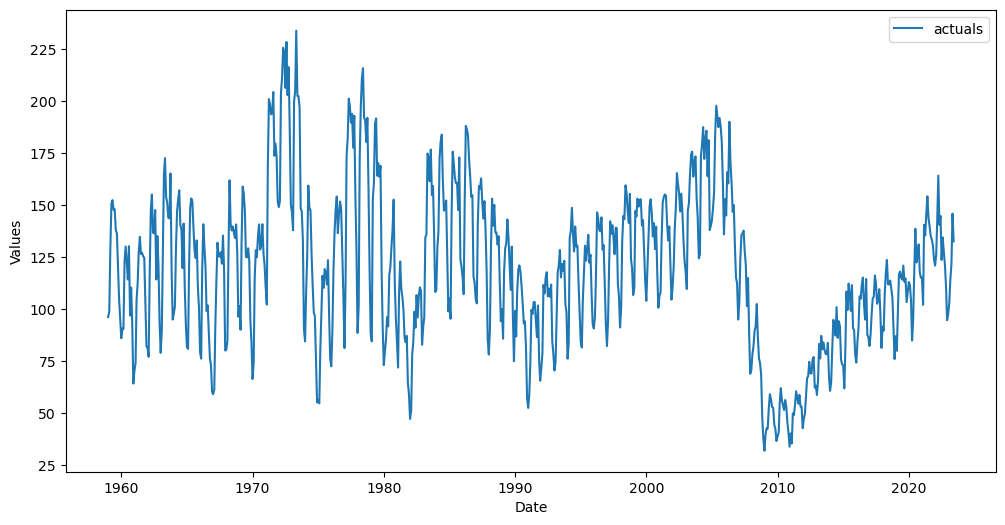

In [10]:
f_new = Forecaster(
    y = df_new.iloc[:,0],
    current_dates = df_new.index,
    future_dates = 24,
)

f_new.plot()
plt.show()

### Add the same Xvars to the new Forecaster object
- The helper function below can assist when you automatically added Xvars
- If you manually added Xvars, you can wrap the selection process in a function and run this new `Forecaster` object through the same function.

In [11]:
infer_apply_Xvar_selection(infer_from=f,apply_to=f_new)

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2023-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=774
    ForecastLength=24
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Apply fitted model from first object onto this new object

In [12]:
f_new.transfer_predict(transfer_from=f,model='rnn',model_type='tf')

23/23 [==============================] - 0s 2ms/step


### Transfer the model's confidence intervals

In [13]:
f_new.transfer_cis(transfer_from=f,model='rnn') # transfer the model's confidence intervals

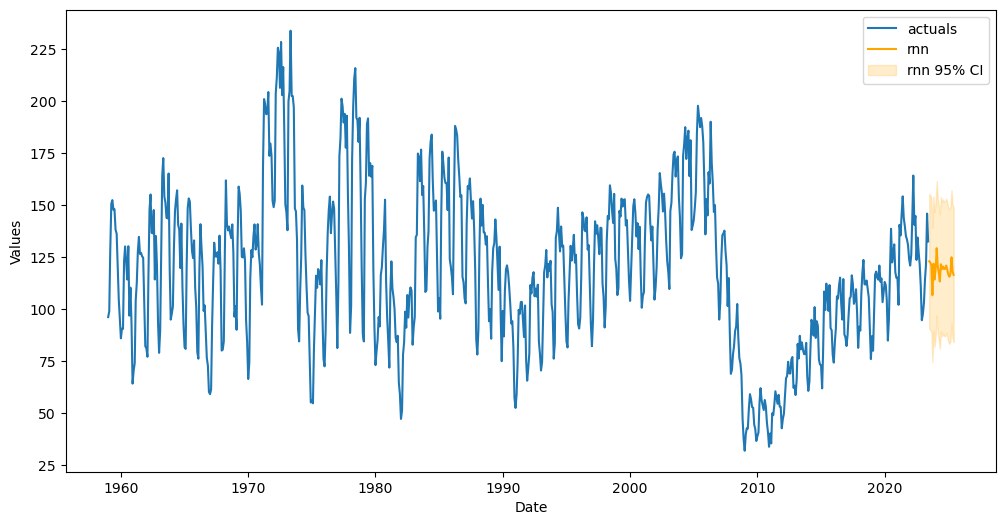

In [14]:
f_new.plot(ci=True)
plt.show()